# Networks

##  Introduction 

This tutorial gives an overview of the microwave network analysis 
features of **skrf**.  For this tutorial, and the rest of the scikit-rf documentation, it is  assumed that **skrf** has been imported as `rf`. Whether or not you follow this convention in your own code is up to you.

In [1]:
import skrf as rf


If this produces an import error, please see [installation ](installation.rst).

## Creating Networks


**skrf** provides an object for a N-port microwave [Network](../api/network.rst). A [Network](../api/network.rst) can be created in a number of ways. One way is from data stored in a touchstone file. 

In [97]:
from skrf import Network, Frequency

ring_slot = Network('data/ring slot.s2p')

	
A short description of the network will be printed out if entered onto the command line
	

In [3]:
ring_slot

2-Port Network: 'ring slot',  75-110 GHz, 201 pts, z0=[ 50.+0.j  50.+0.j]

Networks can also be created by directly passing values for the `frequency`, `s`-paramters  and  port impedance `z0`. 

In [4]:
freq = Frequency(1,10,101,'ghz')
ntwk = Network(frequency=freq, s= [-1, 1j, 0], z0=50, name='slippy') 
ntwk

1-Port Network: 'slippy',  1-10 GHz, 101 pts, z0=[ 50.+0.j]

	
See  [network](../api/network.rst)  for more information on network creation.

## Basic Properties

	
The basic attributes of a microwave [Network](../api/network.rst) are provided by the 
following properties :

* `Network.s` : Scattering Parameter matrix. 
* `Network.z0`  : Port Characteristic Impedance matrix.
* `Network.frequency`  : Frequency Object. 

The [Network](../api/network.rst) object has numerous other properties and methods. If you are using IPython, then these properties and methods can be 'tabbed' out on the command line. 


	In [1]: ring_slot.s<TAB>
	ring_slot.line.s              ring_slot.s_arcl         ring_slot.s_im
	ring_slot.line.s11            ring_slot.s_arcl_unwrap  ring_slot.s_mag
	...


All of the network parameters are represented internally as complex `numpy.ndarray`. The s-parameters are of shape (nfreq, nport, nport)

In [98]:
shape(ring_slot.s)

(201, 2, 2)

## Slicing

You can  slice the `Network.s` attribute any way you want.

In [63]:
ring_slot.s[:11,1,0]  # get first 10 values of S21

array([ 0.61345710+0.36678139j,  0.62181940+0.36403169j,
        0.63024301+0.36109574j,  0.63872415+0.3579682j ,
        0.64725874+0.35464377j,  0.65584238+0.35111711j,
        0.66447037+0.34738295j,  0.67313770+0.34343602j,
        0.68183901+0.33927115j,  0.69056862+0.33488321j,
        0.69932050+0.3302672j ])

Slicing by frequency can also be done directly on Network objects like so 

In [60]:
ring_slot[0:10] #  Network for the first 10 frequency points

2-Port Network: 'ring slot',  75-76 GHz, 10 pts, z0=[ 50.+0.j  50.+0.j]

or  with a human friendly string ,

In [64]:
ring_slot['80-90ghz']

2-Port Network: 'ring slot',  80-90 GHz, 58 pts, z0=[ 50.+0.j  50.+0.j]

Notice that slicing directly on a Network **returns a Network**.  So, a nice way to express slicing in both dimensions is 

In [66]:
ring_slot.s11['80-90ghz'] 

1-Port Network: 'ring slot',  80-90 GHz, 58 pts, z0=[ 50.+0.j]

## Ploting 

Amongst other things, the methods of the [Network](../api/network.rst) class provide convenient ways to plot components of the network parameters, 

* `Network.plot_s_db` : plot magnitude of s-parameters in log scale
* `Network.plot_s_deg` : plot phase of s-parameters in degrees
* `Network.plot_s_smith` : plot complex s-parameters on Smith Chart
* ...

If you would like to use skrf's plot styling,

In [74]:
rf.setup_pylab()
rf.stylely()

/home/alex/anaconda3/envs/py35/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


	
To plot all four s-parameters of the `ring_slot` on the Smith Chart.

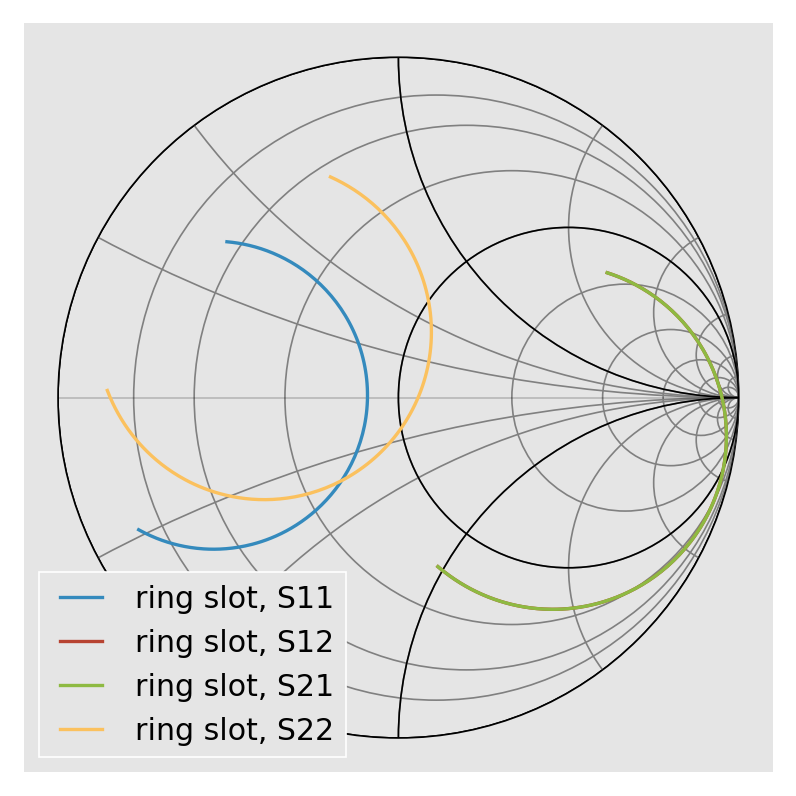

In [75]:
ring_slot.plot_s_smith()

Combining this with the slicing features, 

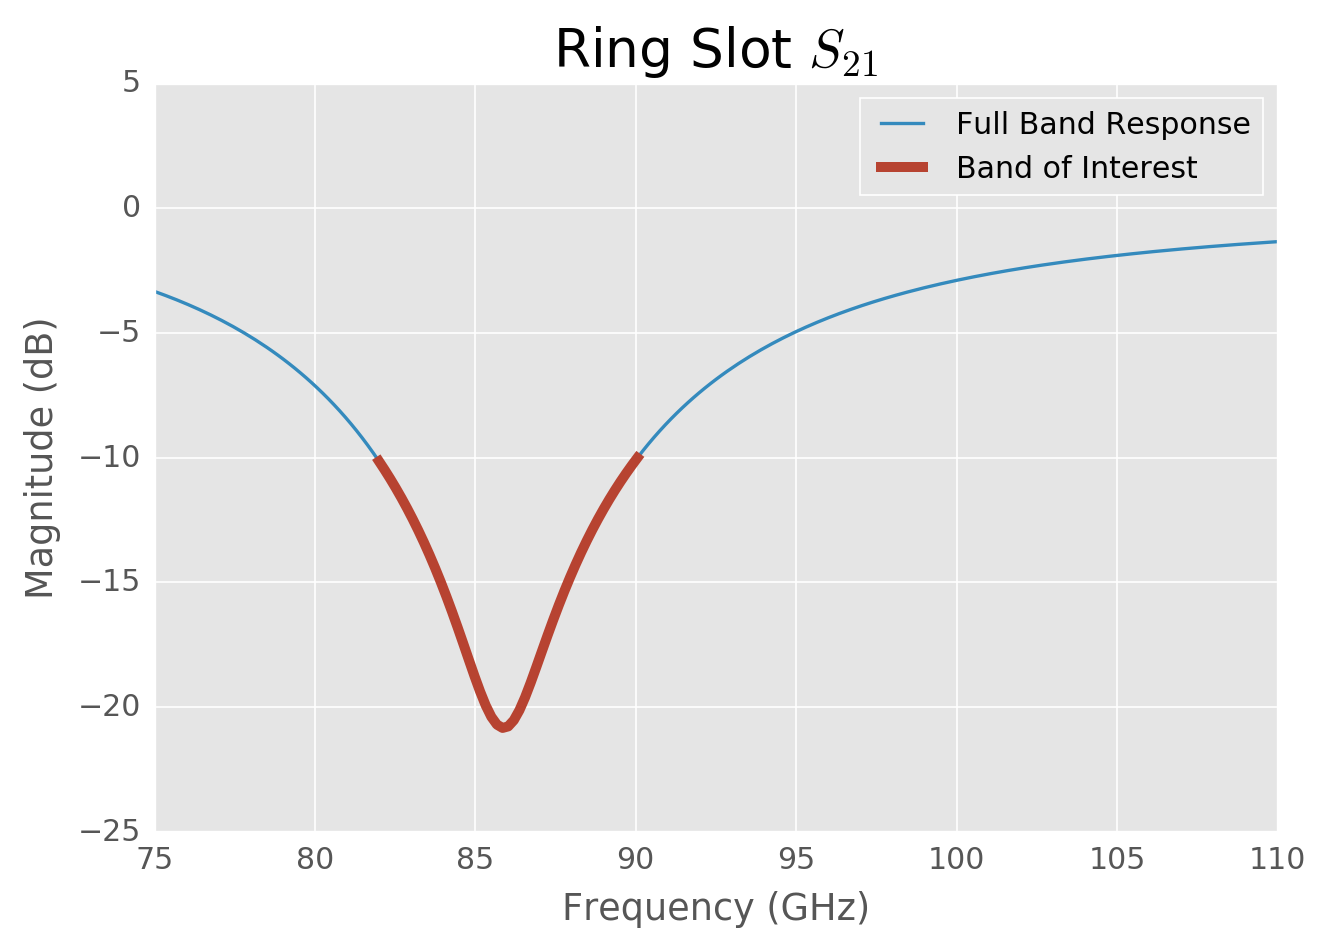

In [101]:
from matplotlib import pyplot as plt

plt.title('Ring Slot $S_{21}$')

ring_slot.s11.plot_s_db(label='Full Band Response')
ring_slot.s11['82-90ghz'].plot_s_db(lw=3,label='Band of Interest')

For more detailed information about plotting see [Plotting](Plotting).   


## Operators

### Arithmetic Operations 
	
Element-wise mathematical operations on the scattering parameter matrices are accessible through overloaded operators. To illustrate their usage, load a couple  Networks stored in the `data` module. 

In [77]:
from skrf.data import wr2p2_short as short 
from skrf.data import wr2p2_delayshort as delayshort 


short - delayshort
short + delayshort
short * delayshort
short / delayshort


1-Port Network: 'wr2p2,short',  330-500 GHz, 201 pts, z0=[ 50.+0.j]

All of these operations return [Network](../api/network.rst) types.  For example, to plot the complex difference  between  `short` and `delay_short`,

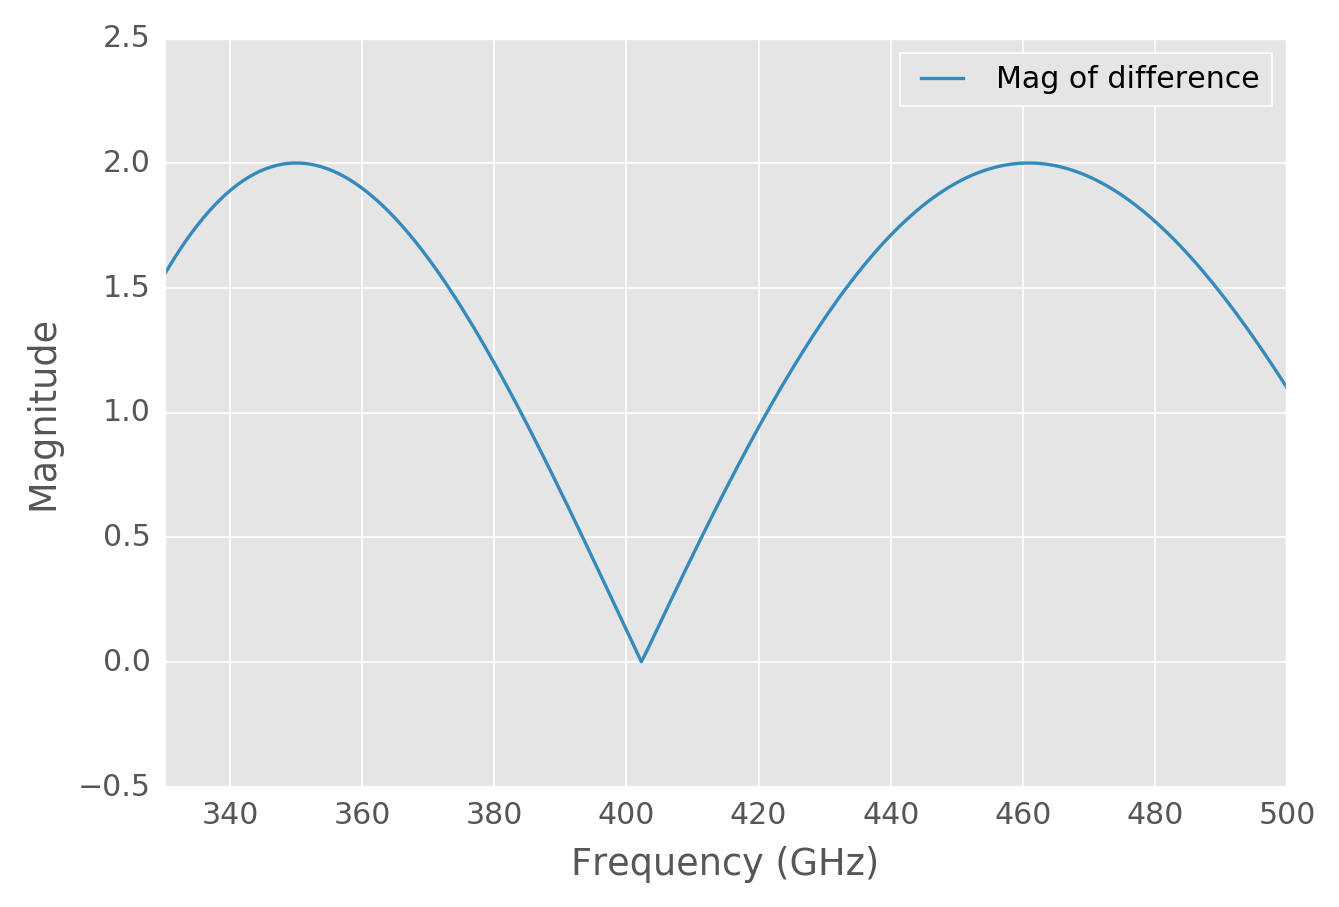

In [102]:
difference = (short- delayshort)
difference.plot_s_mag(label='Mag of difference')

Another common application is calculating the phase difference using the division operator,

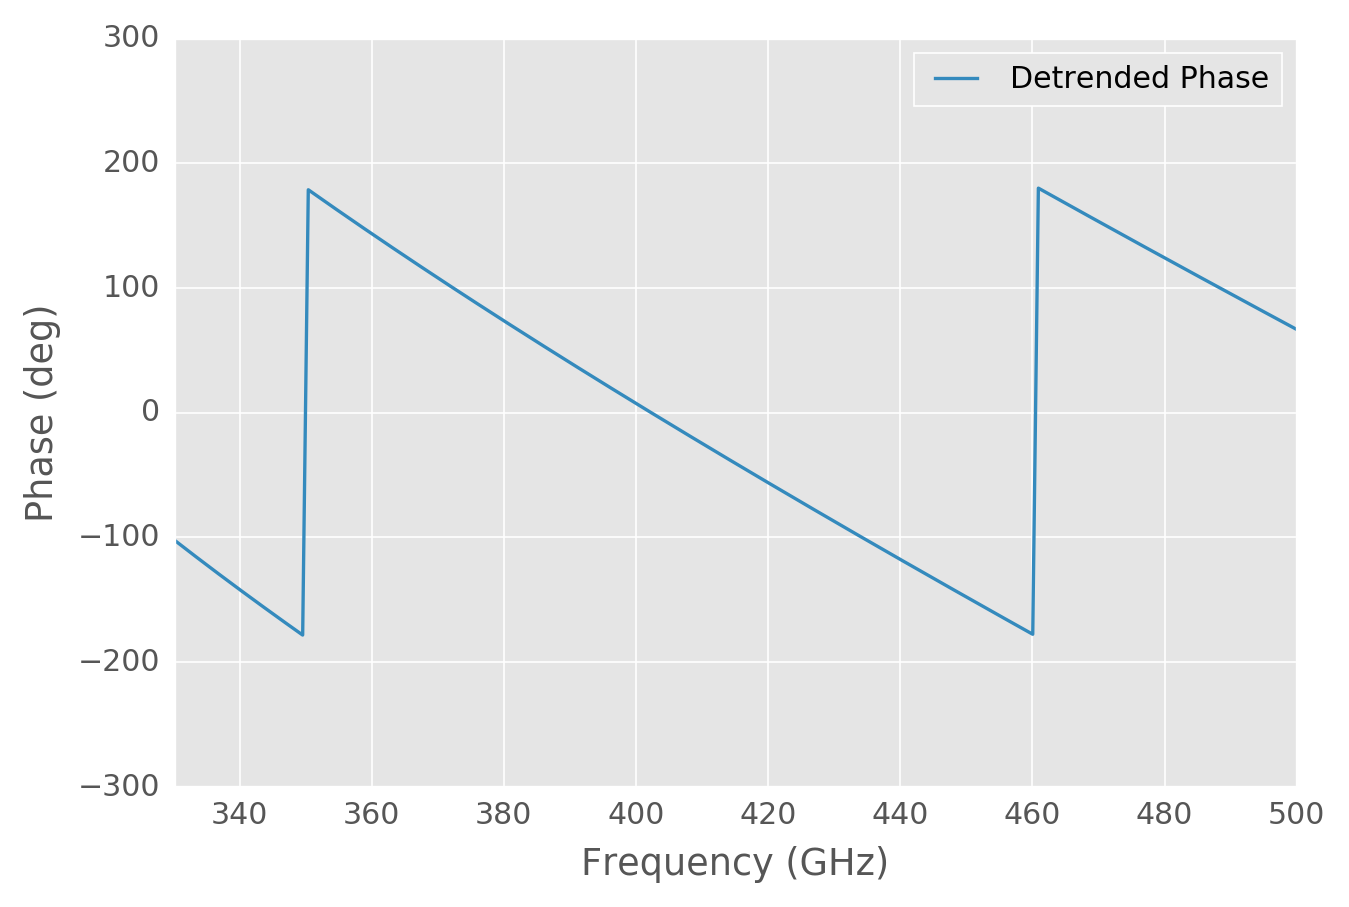

In [103]:
(delayshort/short).plot_s_deg(label='Detrended Phase')

Linear operators can also be used with scalars or an `numpy.ndarray`  that ais the same length as the [Network](../api/network.rst). 

In [80]:
hopen = (short*-1)
hopen.s[:3,...]

array([[[ 1.-0.j]],

       [[ 1.-0.j]],

       [[ 1.-0.j]]])

In [81]:
rando =  hopen *rand(len(hopen))
rando.s[:3,...]

array([[[ 0.39734795+0.j]],

       [[ 0.79314330+0.j]],

       [[ 0.91204897+0.j]]])

.. notice :: 	
    
    Note that if you multiply a Network by an `numpy.ndarray`  be sure to place the array on right side.

### Cascading and De-embedding

Cascading and de-embeding 2-port Networks can also be done though operators. The :func:`cascade` function can be called through the power operator,  `**`. To calculate a new network which is the cascaded connection of the two individual Networks `line` and `short`, 

In [82]:
short = rf.data.wr2p2_short
line = rf.data.wr2p2_line
delayshort = line ** short

De-embedding  can be accomplished by cascading the *inverse* of a network. The inverse of a network is accessed through the property :attr:`Network.inv`. To de-embed the `short` from `delay_short`,

In [83]:
short_2 = line.inv ** delayshort

short_2==short

True

Comparison operators also work with networks.

## Connecting Multi-ports 

**skrf** supports the connection of arbitrary ports of N-port networks. It accomplishes this using an algorithm called sub-network growth[[1]](#References),  available through the function `connect()`. Terminating one port of an ideal 3-way splitter can be done like so,

In [84]:
tee = rf.data.tee
tee

3-Port Network: 'tee',  330-500 GHz, 201 pts, z0=[ 50.+0.j  50.+0.j  50.+0.j]

	

To connect port `1` of the tee, to port `0` of the delay short,

In [85]:
terminated_tee = rf.connect(tee,1,delayshort,0)
terminated_tee

2-Port Network: 'tee',  330-500 GHz, 201 pts, z0=[ 50.+0.j  50.+0.j]

Note that this function takes into account port impedances. If two connected ports have different port impedances,  an appropriate impedance mismatch is inserted.
	
## Interpolation and Concatenation

A common need is to change the number of frequency points of a [Network](../api/network.rst). To use the operators and cascading functions the networks involved must have matching frequencies, for instance. If two networks have different frequency information, then an error will be raised, 

In [86]:
from skrf.data import wr2p2_line1 as line1

line1

2-Port Network: 'wr2p2,line1',  330-500 GHz, 201 pts, z0=[ 50.+0.j  50.+0.j]

    line1+line
    
    ---------------------------------------------------------------------------
    IndexError                                Traceback (most recent call last)
    <ipython-input-49-82040f7eab08> in <module>()
    ----> 1 line1+line

    /home/alex/code/scikit-rf/skrf/network.py in __add__(self, other)
        500 
        501         if isinstance(other, Network):
    --> 502             self.__compatable_for_scalar_operation_test(other)
        503             result.s = self.s + other.s
        504         else:

    /home/alex/code/scikit-rf/skrf/network.py in __compatable_for_scalar_operation_test(self, other)
        701         '''
        702         if other.frequency  != self.frequency:
    --> 703             raise IndexError('Networks must have same frequency. See `Network.interpolate`')
        704 
        705         if other.s.shape != self.s.shape:

    IndexError: Networks must have same frequency. See `Network.interpolate`


	
This problem can be solved by interpolating one of Networks allong the frequency axis using `Network.resample`. 

In [87]:
line1.resample(201)
line1

2-Port Network: 'wr2p2,line1',  330-500 GHz, 201 pts, z0=[ 50.+0.j  50.+0.j]

And now we can do things

In [88]:
line1+line

2-Port Network: 'wr2p2,line1',  330-500 GHz, 201 pts, z0=[ 50.+0.j  50.+0.j]

You can also interpolate from a `Frequency` object. For example, 

In [104]:
line.interpolate_from_f(line1.frequency)

2-Port Network: 'wr2p2,line',  330-500 GHz, 201 pts, z0=[ 50.+0.j  50.+0.j]

A related application is the need to combine Networks which cover different frequency ranges. Two  Netwoks can be concatenated (aka stitched) together using `stitch`, which  concatenates networks along their frequency axis. To combine a WR-2.2 Network with a WR-1.5 Network, 
 

In [89]:
from skrf.data import wr2p2_line, wr1p5_line
	
big_line = rf.stitch(wr2p2_line, wr1p5_line)
big_line

2-Port Network: 'wr2p2,line',  330-750 GHz, 402 pts, z0=[ 50.+0.j  50.+0.j]

## Reading and Writing 


For long term data storage, **skrf** has support for reading and partial support for writing  [touchstone file format](http://en.wikipedia.org/wiki/Touchstone_file). Reading is accomplished with the Network initializer as shown above,  and writing with the method  `Network.write_touchstone()`.

For **temporary** data storage, **skrf** object can be [pickled](http://docs.python.org/2/library/pickle.html) with  the functions `skrf.io.general.read` and `skrf.io.general.write`.  The reason to use temporary pickles over touchstones is that they store all attributes of a network, while touchstone files only store partial information. 

In [90]:
rf.write('data/myline.ntwk',line) # write out Network using pickle

In [91]:
ntwk = Network('data/myline.ntwk') # read Network using pickle

Frequently there is an entire directory of files that need to be analyzed. `rf.read_all`  creates Networks from all files in a directory quickly.  To load all **skrf** files in the `data/` directory which contain the string `'wr2p2'`.

In [92]:
dict_o_ntwks = rf.read_all(rf.data.pwd, contains = 'wr2p2')
dict_o_ntwks

{'wr2p2,delayshort': 1-Port Network: 'wr2p2,delayshort',  330-500 GHz, 201 pts, z0=[ 50.+0.j],
 'wr2p2,line': 2-Port Network: 'wr2p2,line',  330-500 GHz, 201 pts, z0=[ 50.+0.j  50.+0.j],
 'wr2p2,line1': 2-Port Network: 'wr2p2,line1',  330-500 GHz, 101 pts, z0=[ 50.+0.j  50.+0.j],
 'wr2p2,short': 1-Port Network: 'wr2p2,short',  330-500 GHz, 201 pts, z0=[ 50.+0.j]}

## Other Parameters	

This tutorial focuses on s-parameters, but other network represenations are available as well. Impedance  and Admittance Parameters can be accessed through the parameters `Network.z` and `Network.y`, respectively. Scalar components of complex parameters, such as  `Network.z_re`, `Network.z_im` and plotting methods like are available as well.

Other parameters are only available for 2-port networks, such as wave cascading parameters (`Network.t`), and  ABCD-parameters (`Network.a`)

In [109]:
ring_slot.z[:3,...]

array([[[ 0.88442687+28.15350224j,  0.94703504+30.46757222j],
        [ 0.94703504+30.46757222j,  1.04344170+43.45766805j]],

       [[ 0.91624901+28.72415928j,  0.98188607+31.09594438j],
        [ 0.98188607+31.09594438j,  1.08168411+44.17642274j]],

       [[ 0.94991736+29.31694632j,  1.01876516+31.74874257j],
        [ 1.01876516+31.74874257j,  1.12215451+44.92215712j]]])

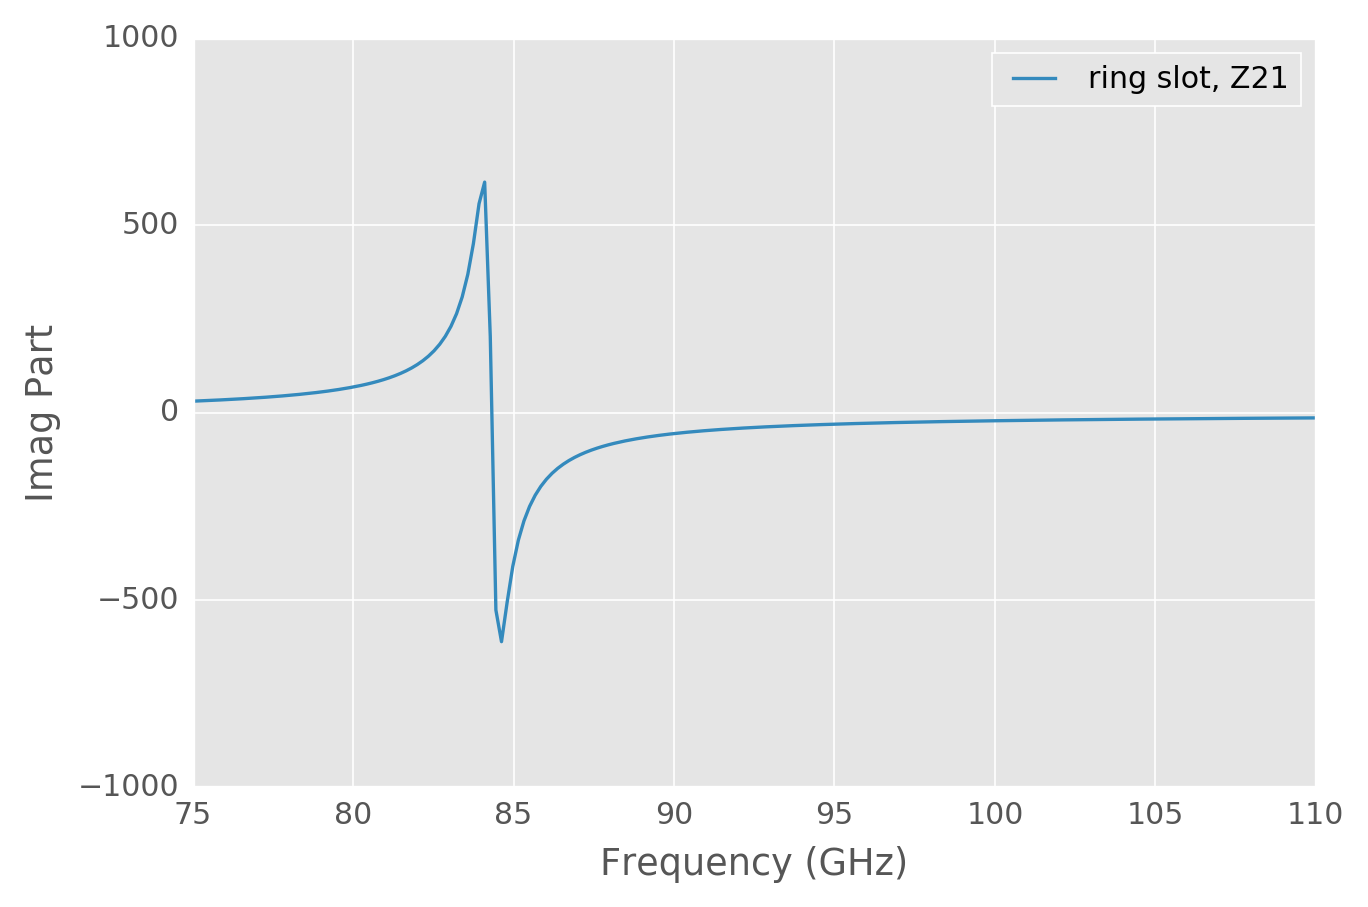

In [110]:
ring_slot.plot_z_im(m=1,n=0)

##  Conclusion

There are many more features of Networks that can be found in [networks](networks.rst)

## References


[1] Compton, R.C.; , "Perspectives in microwave circuit analysis," Circuits and Systems, 1989., Proceedings of the 32nd Midwest Symposium on , vol., no., pp.716-718 vol.2, 14-16 Aug 1989. URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=101955&isnumber=3167
